In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
# File Path (Adjust if your folder structure is different)
INPUT_PATH = '../data/cleaned_data_final.csv'

# Load Data
df = pd.read_csv(INPUT_PATH)

# NOTE: We intentionally keep 'Road' (Traffic) and 'Water' (Transport) accidents.
# Objective: To compare the frequency of technological/human-made accidents vs. natural disasters.

# Design Settings (Professional Look)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 150
sns.set_style("whitegrid") 

# Color Palette
# Primary: General Trends, Danger: Casualties, Money: Economic Loss, Neutral: Context
COLORS = {"primary": "#1f77b4", "danger": "#d62728", "money": "#2ca02c", "neutral": "#7f7f7f"}

# Helper Function: Find the biggest event of a specific year
def get_top_event(year, metric):
    """
    Returns the name and value of the disaster with the highest impact in a given year.
    metric: 'casualties' or 'economic_loss_usd'
    """
    yearly_data = df[df['year'] == year]
    if yearly_data.empty: return None, 0
    
    # Find the event with max value
    top_event = yearly_data.sort_values(by=metric, ascending=False).iloc[0]
    
    # Return formatted string (e.g., "Turkey Earthquake")
    return f"{top_event['country']} {top_event['disaster_type']}", top_event[metric]

print("Setup Complete. Data Loaded.")

Setup Complete. Data Loaded.


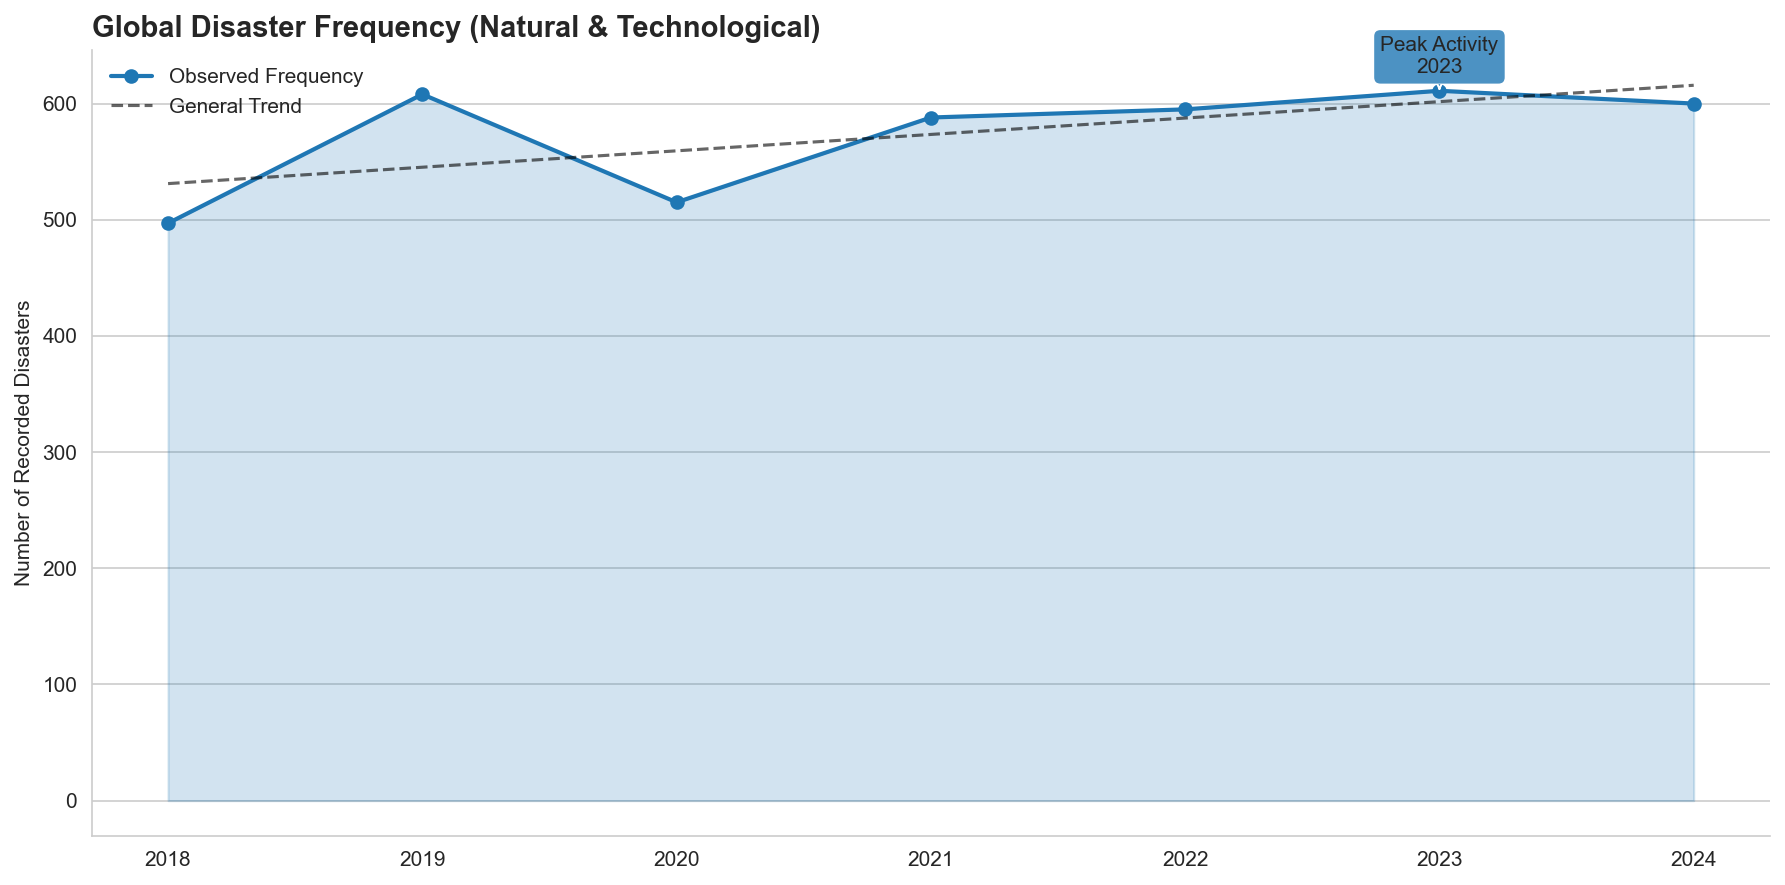

In [6]:
# ==========================================
# 2. FREQUENCY ANALYSIS: GLOBAL DISASTER TRENDS
# ==========================================
# Visualize the aggregate annual frequency of all recorded disaster events
# to identify increasing or decreasing global risk patterns.

annual_counts = df['year'].value_counts().sort_index()
years = annual_counts.index
counts = annual_counts.values

fig, ax = plt.subplots(figsize=(12, 6))

# Area Plot
ax.fill_between(years, counts, color=COLORS["primary"], alpha=0.2)
ax.plot(years, counts, color=COLORS["primary"], marker='o', linewidth=2, label="Observed Frequency")

# Trend Line
z = np.polyfit(years, counts, 1)
p = np.poly1d(z)
ax.plot(years, p(years), "k--", alpha=0.6, label=f"General Trend")

# Mark the Peak Year (Annotation)
max_year = annual_counts.idxmax()
max_val = annual_counts.max()

ax.annotate(f"Peak Activity\n{max_year}",
            xy=(max_year, max_val),
            xytext=(max_year, max_val + 15),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="#1f77b4", ec="none", alpha=0.8)) # Box for annotation

ax.set_title("Global Disaster Frequency (Natural & Technological)", fontsize=14, fontweight='bold', loc='left')
ax.set_ylabel("Number of Recorded Disasters")
ax.legend(loc="upper left",frameon=False)
ax.grid(axis='x', visible=False)

sns.despine()
plt.tight_layout()
plt.show()

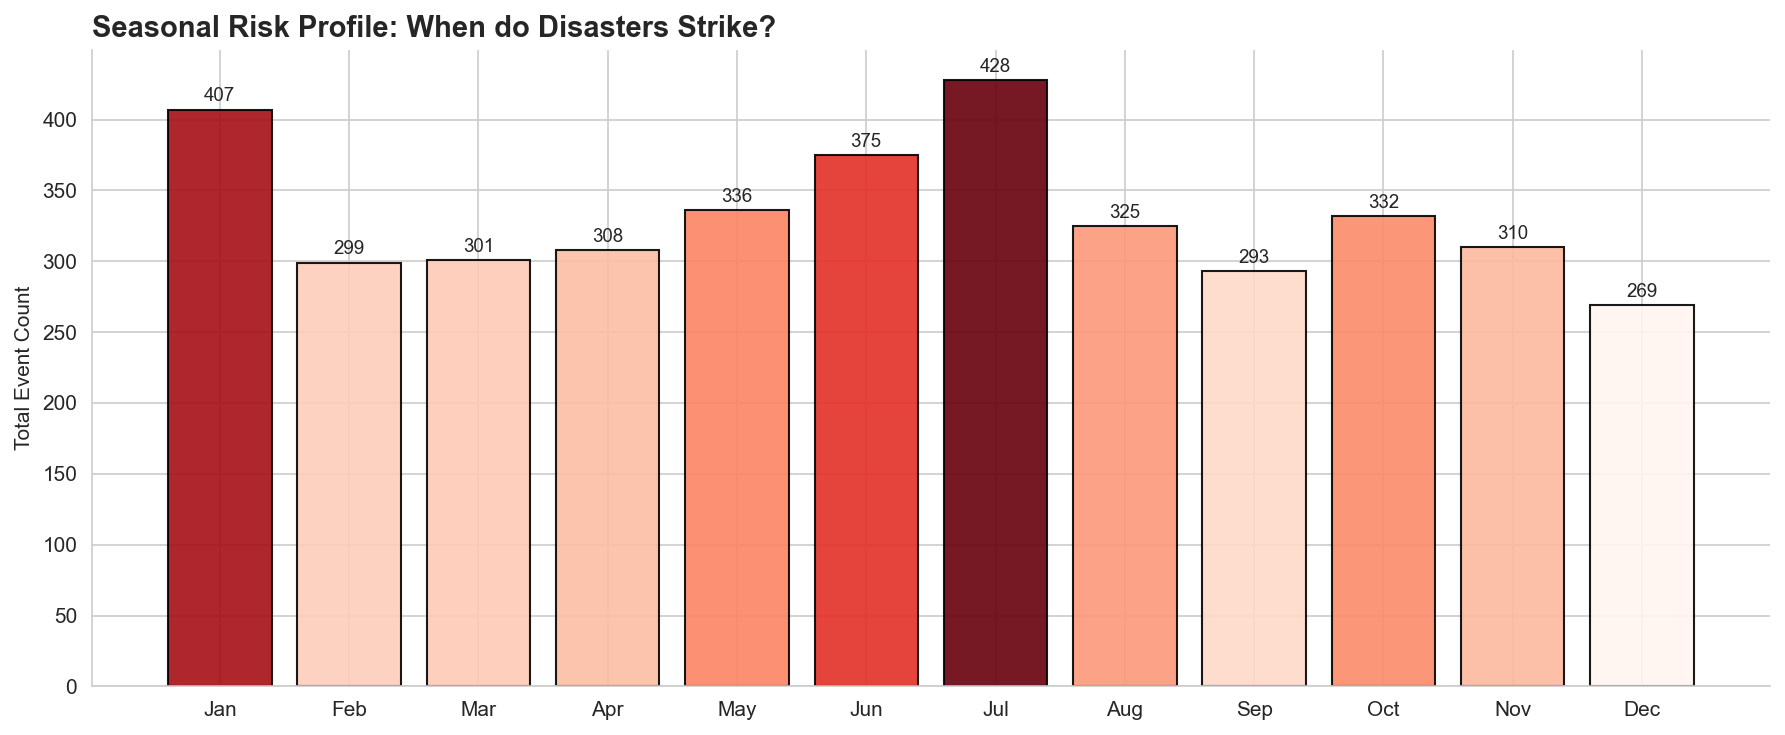

In [7]:
# ==========================================
# 3. SEASONAL PERIODICITY ASSESSMENT: MONTHLY RISK DISTRIBUTION
# ==========================================
# Determine seasonal patterns in disaster occurrence to identify 
# high-risk months (e.g., monsoon seasons, hurricane windows).

# Filter for valid months (exclude missing/zero values)
monthly_counts = df[df['month'] > 0]['month'].value_counts().sort_index()

# Normalize values for color mapping (Darker Red = Higher Frequency)
norm_counts = (monthly_counts - monthly_counts.min()) / (monthly_counts.max() - monthly_counts.min())
colors_seasonal = plt.cm.Reds(norm_counts)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(monthly_counts.index, monthly_counts.values, color=colors_seasonal, edgecolor='black', alpha=0.9)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 3, f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_title("Seasonal Risk Profile: When do Disasters Strike?", fontsize=14, fontweight='bold', loc='left')
ax.set_ylabel("Total Event Count")

sns.despine()
plt.tight_layout()
plt.show()

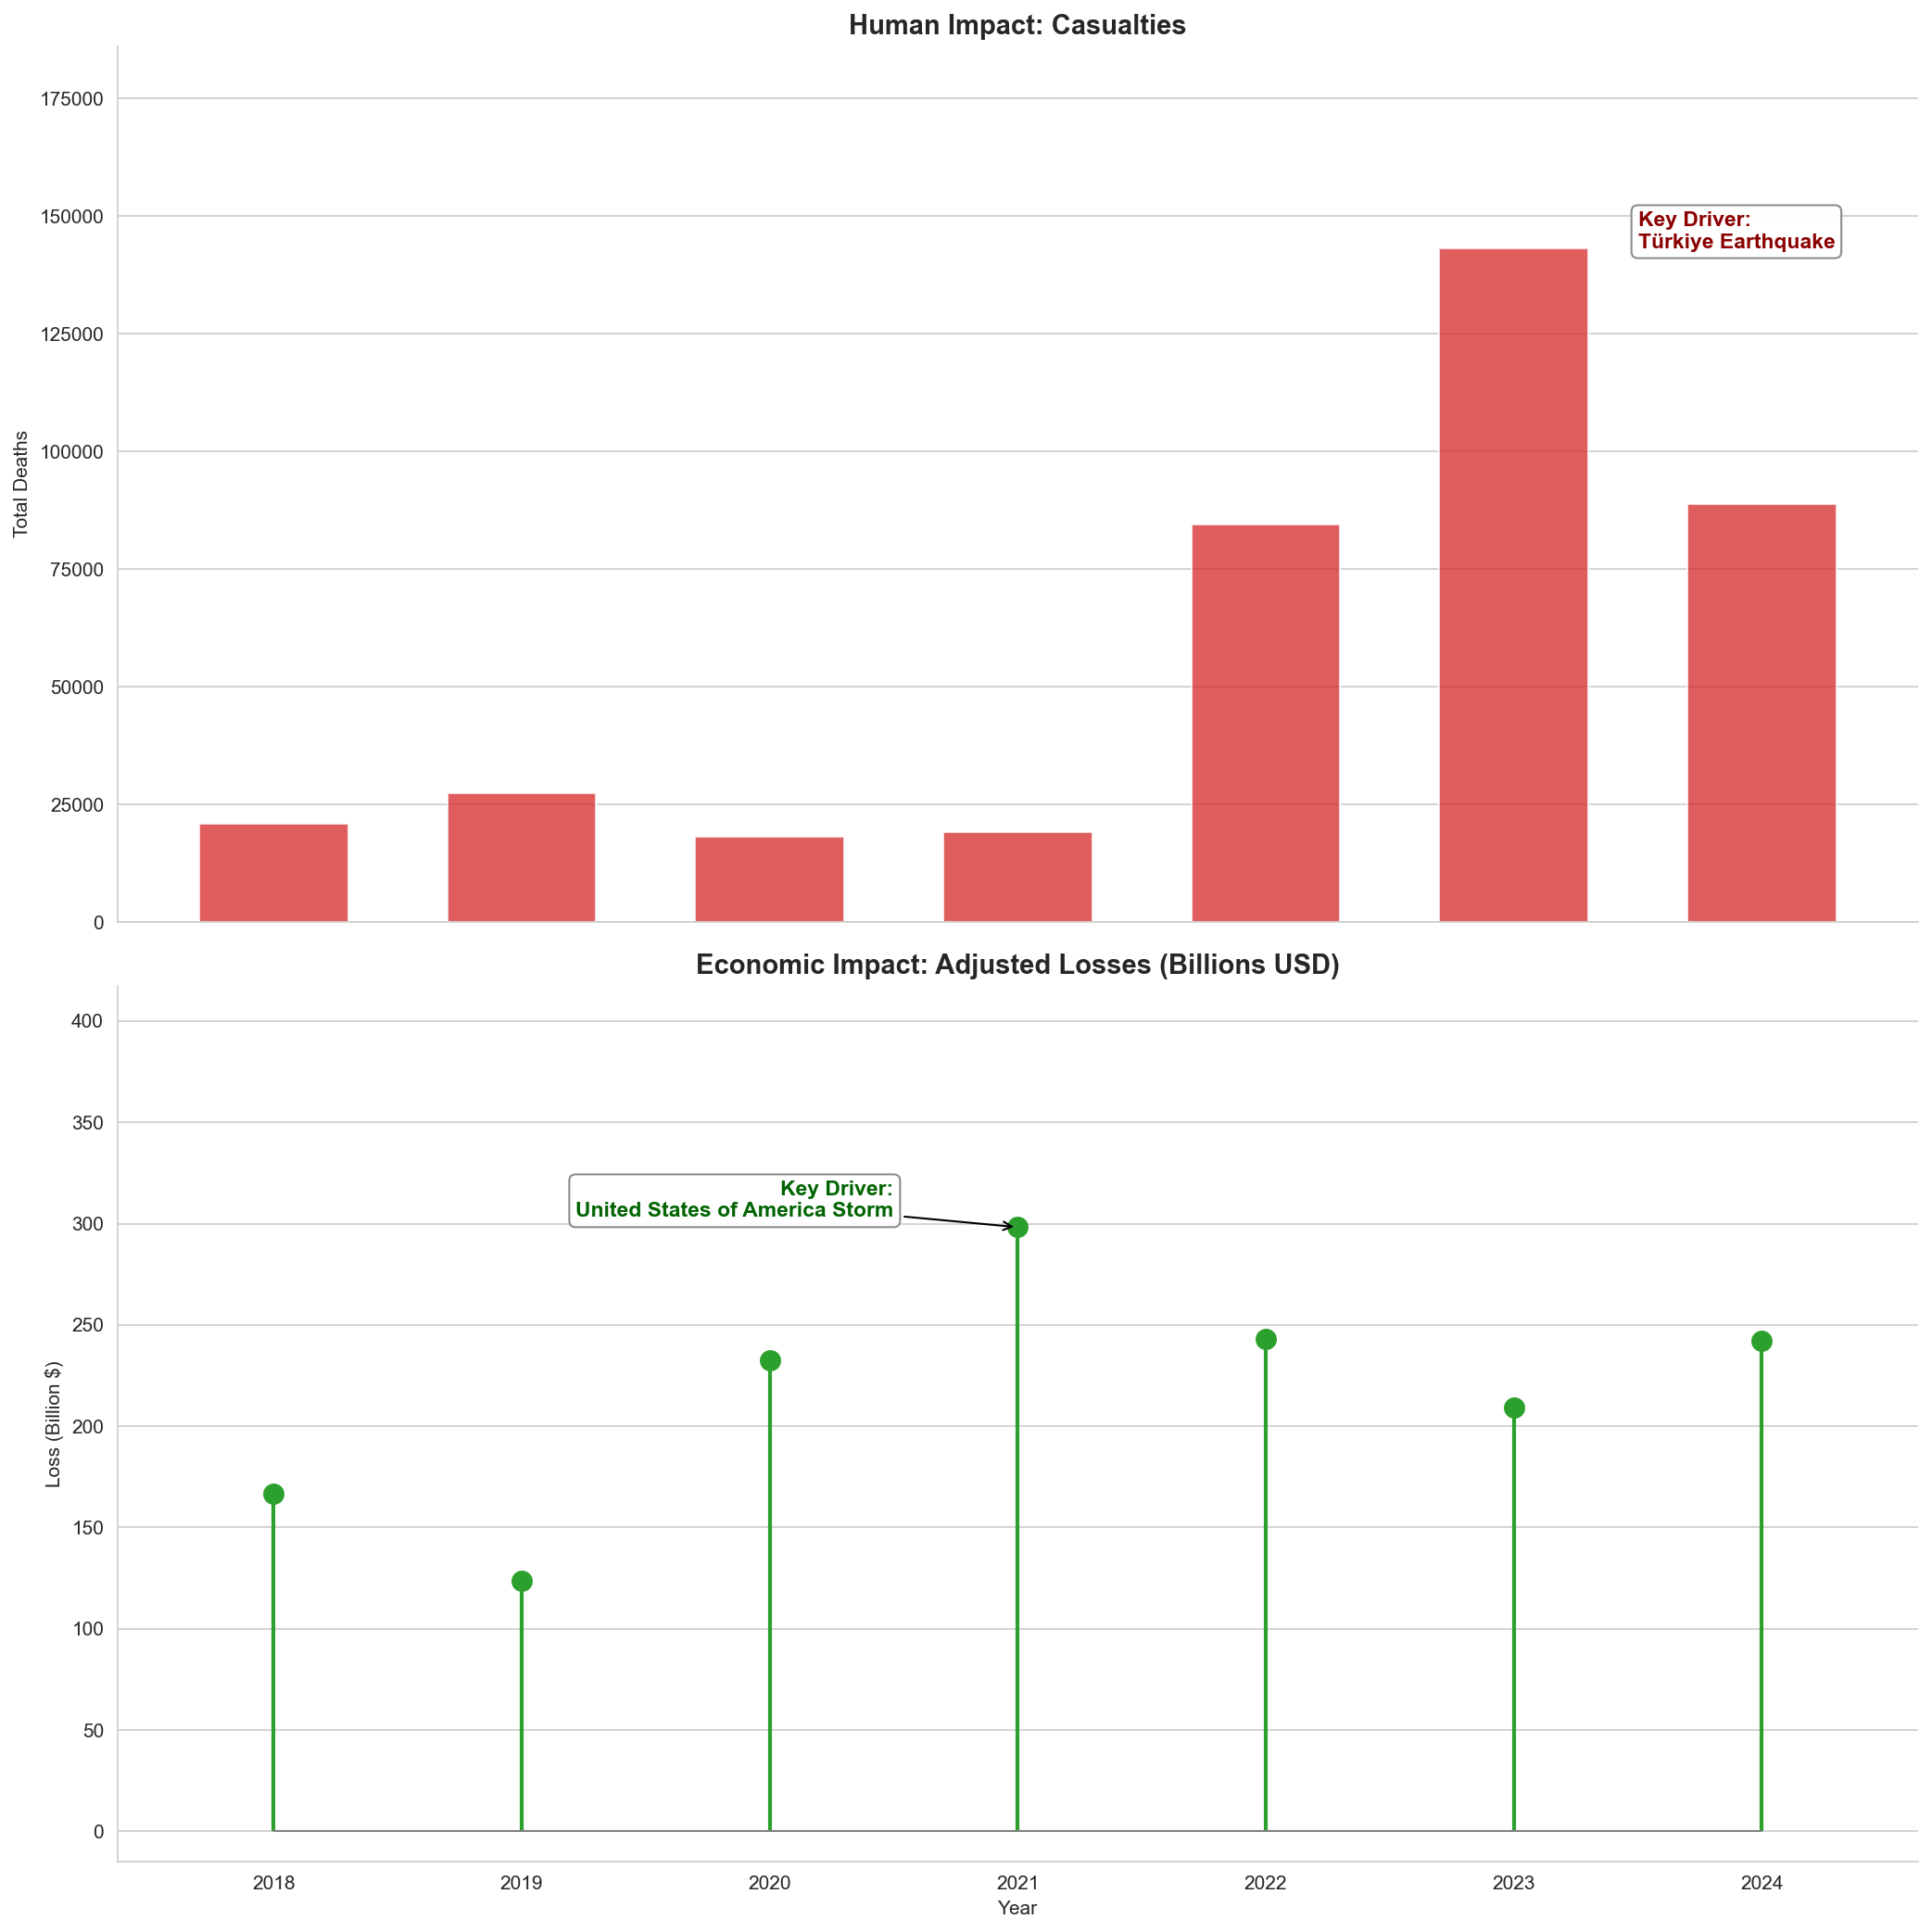

In [9]:
# ================================================================
# 4. AGGREGATE IMPACT METRICS: HUMAN CASUALTIES VS. ECONOMIC LOSSES
# =================================================================
# Compare the annual trends of human fatalities against financial damages
# to understand the evolving severity of disasters. Annotations highlight key driver events.


impact_stats = df.groupby('year')[['casualties', 'economic_loss_usd']].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

# --- CASUALTIES (Bar Chart) ---
ax1.bar(impact_stats.index, impact_stats['casualties'], color=COLORS["danger"], alpha=0.75, width=0.6)

# Annotation for Casualties (Find and annotate the deadliest event)
peak_death_year = impact_stats['casualties'].idxmax()
event_name, _ = get_top_event(peak_death_year, 'casualties')
max_death_val = impact_stats.loc[peak_death_year, 'casualties']

ax1.annotate(f"Key Driver:\n{event_name}",
             xy=(peak_death_year, max_death_val),
             xytext=(peak_death_year + 0.5, max_death_val),
             arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"),
             fontsize=11, fontweight='bold', color='darkred', ha='left',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)) # Box for readability

ax1.set_ylim(top=max_death_val * 1.3) # Increase y-limit to accommodate text
ax1.set_title("Human Impact: Casualties", fontsize=14, fontweight='bold')
ax1.set_ylabel("Total Deaths")
ax1.grid(axis='x', visible=False)


# --- ECONOMIC LOSS (Lollipop Chart) ---
# Convert to Billions
loss_billions = impact_stats['economic_loss_usd'] / 1e6

# Draw Lollipop chart (Stem Plot)
markerline, stemlines, baseline = ax2.stem(loss_billions.index, loss_billions)
plt.setp(stemlines, 'color', COLORS["money"], 'linewidth', 2)
plt.setp(markerline, 'color', COLORS["money"], 'markersize', 10)
plt.setp(baseline, 'color', 'gray', 'linewidth', 1)

# Annotation for Economy (Find and annotate the most costly event)
peak_loss_year = loss_billions.idxmax()
event_name_econ, _ = get_top_event(peak_loss_year, 'economic_loss_usd')
max_loss_val = loss_billions[peak_loss_year]

ax2.annotate(f"Key Driver:\n{event_name_econ}",
             xy=(peak_loss_year, max_loss_val),
             xytext=(peak_loss_year - 0.5, max_loss_val + 5), # Shift left and up
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=11, fontweight='bold', color='darkgreen', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)) # Box for readability

ax2.set_ylim(top=max_loss_val * 1.4)
ax2.set_title("Economic Impact: Adjusted Losses (Billions USD)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Loss (Billion $)")
ax2.set_xlabel("Year")
ax2.set_xticks(impact_stats.index)
ax2.grid(axis='x', visible=False)

sns.despine()
plt.tight_layout()
plt.show()

Analyzing Top 4 Types: ['Flood', 'Storm', 'Road', 'Water']


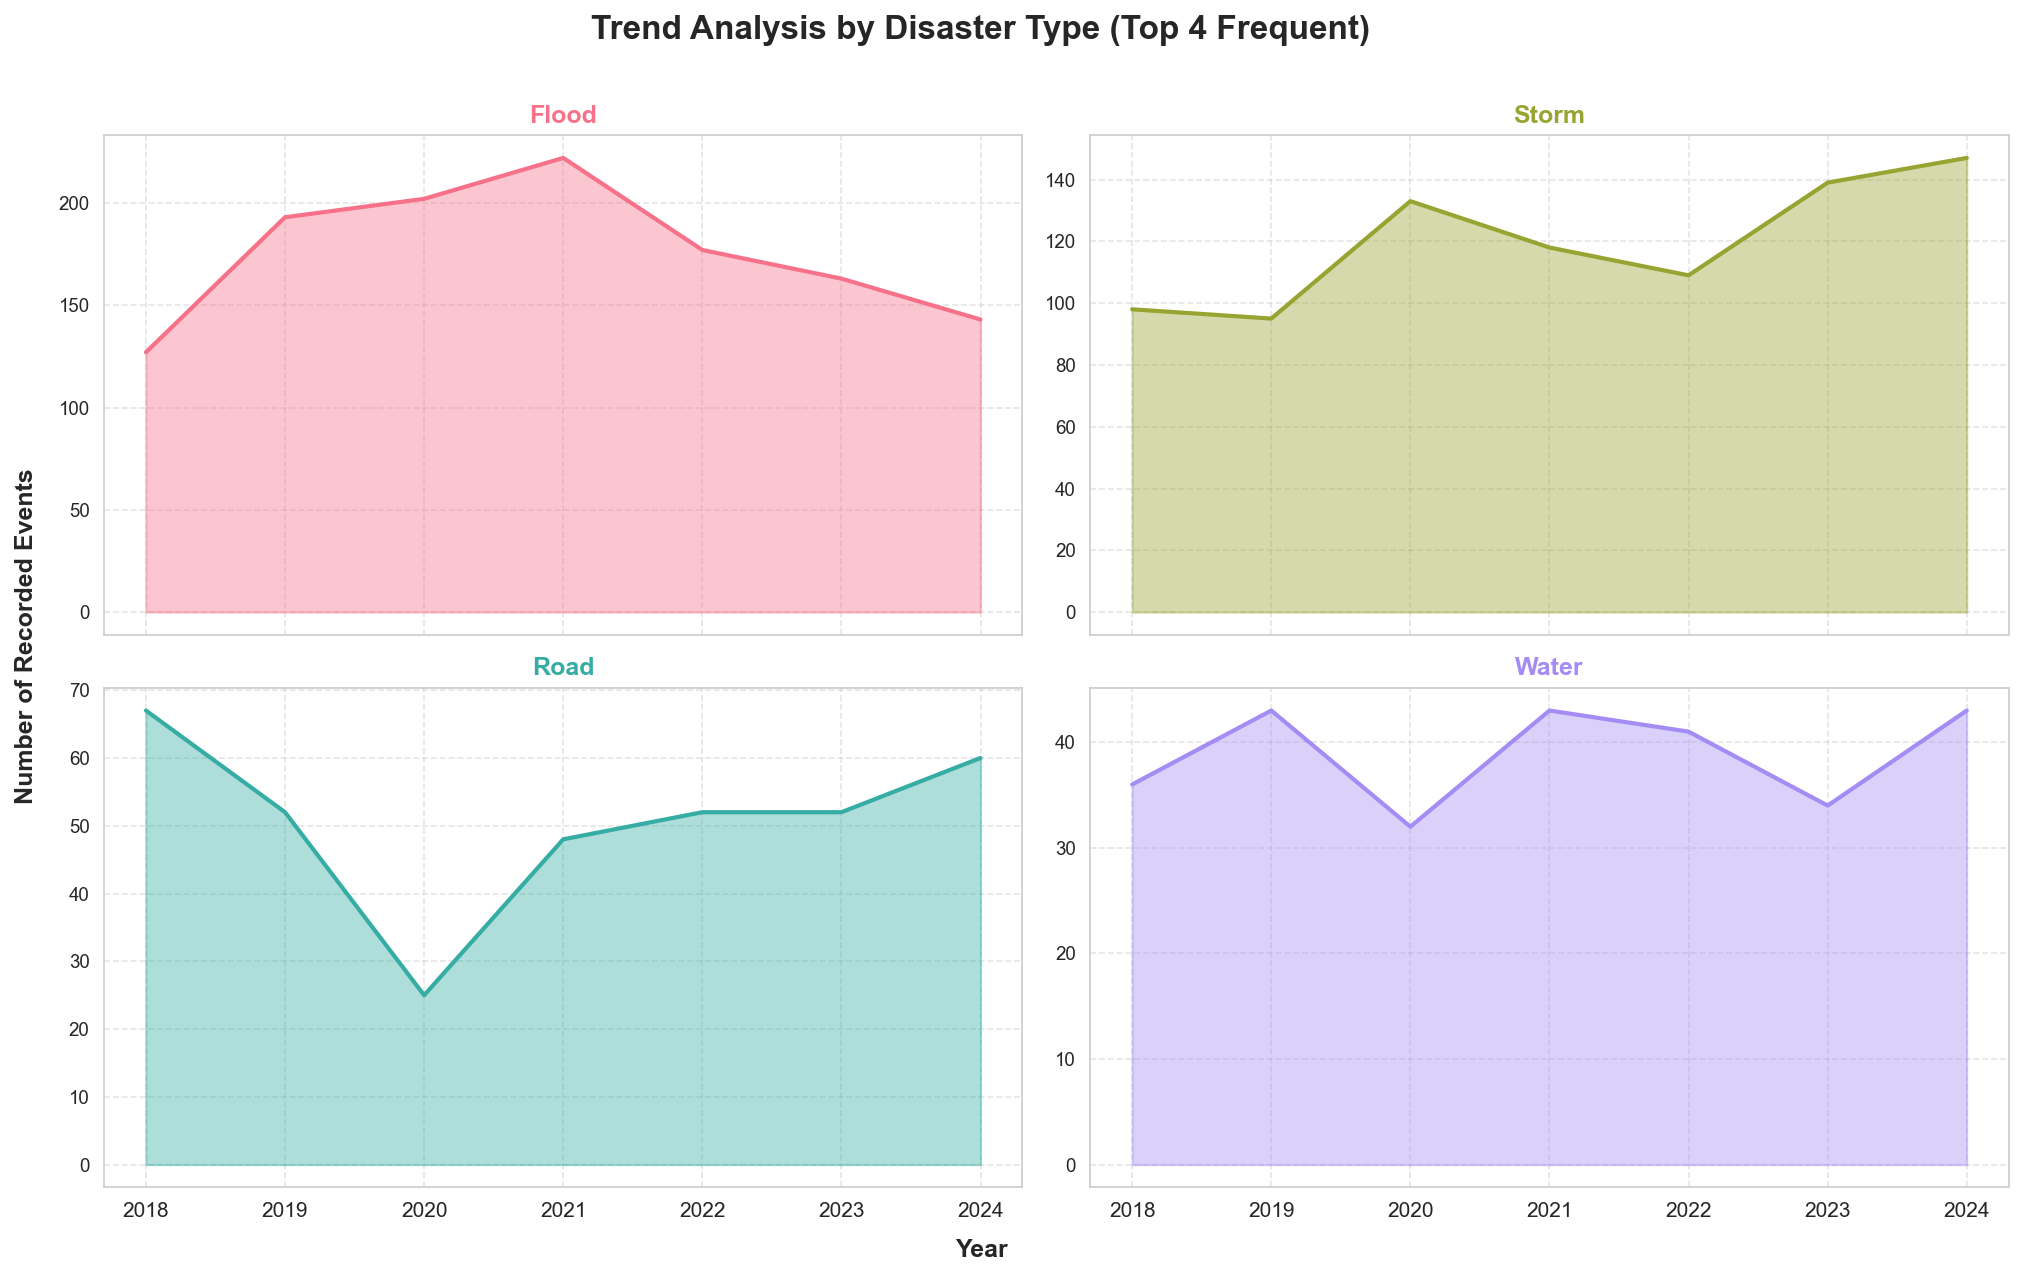

In [10]:
# ==========================================
# 5. CATEGORY-SPECIFIC TREND EVOLUTION 
# ==========================================
# Isolate and visualize the frequency trends of the top 4 most common 
# disaster types to detect category-specific patterns without overlapping noise.

# Find the top 4 most frequent disaster types (including Road/Traffic accidents)
top_types = df['disaster_type'].value_counts().head(4).index
print(f"Analyzing Top 4 Types: {list(top_types)}")

# Filter the dataframe to include only these 4 types
df_top = df[df['disaster_type'].isin(top_types)]

# Create a pivot table (Year x Type) to get counts for each year
type_trends = df_top.groupby(['year', 'disaster_type']).size().unstack(fill_value=0)

# Create a 2x2 Grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True) # Height increased to 9 for better spacing
axes = axes.flatten()
palette = sns.color_palette("husl", 4) # Use distinct colors

for i, dtype in enumerate(top_types):
    ax = axes[i]
    if dtype in type_trends:
        trend_data = type_trends[dtype]
        
        # Area Plot visualization
        ax.fill_between(trend_data.index, trend_data.values, color=palette[i], alpha=0.4)
        ax.plot(trend_data.index, trend_data.values, color=palette[i], linewidth=2)
        
        ax.set_title(dtype, fontsize=12, fontweight='bold', color=palette[i])
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Ensure Y-axis labels are readable for each small plot
        ax.tick_params(axis='y', labelsize=9)

# Global Axis Labels (Common X and Y labels)
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=12, fontweight='bold')
fig.text(0.04, 0.5, 'Number of Recorded Events', va='center', rotation='vertical', fontsize=12, fontweight='bold')

fig.suptitle("Trend Analysis by Disaster Type (Top 4 Frequent)", fontsize=16, fontweight='bold', y=0.96)

# Layout adjustment (rect parameter prevents the global labels from being cut off)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()